## Step 1

In [1]:
# Step1: Install the required libraries
# pip install datasets sentence-transformers transformers faiss-cpu tqdm
# Import essential libraries
import json
import numpy as np
import time
from datasets import load_dataset                     # Load the SQuAD dataset
from sentence_transformers import SentenceTransformer # Dense encoder (MiniLM / BioBERT)
from transformers import pipeline                      # HuggingFace QA pipeline (DistilBERT)
import faiss                                           # FAISS for dense vector indexing
from tqdm import tqdm                                  # Progress bar


## Step 2

In [2]:
# Step 2: Load the pre-trained models
# Load the SQuAD validation set (5,000 examples)
dataset = load_dataset("squad", "plain_text")
corpus_data = dataset['validation']

# Extract context passages, questions, and ground-truth answers
corpus = [item['context'] for item in corpus_data]
questions = [item['question'] for item in corpus_data.select(range(5000))]
answers = [item['answers']['text'][0] for item in corpus_data.select(range(5000))]


## Step 3

In [3]:
# Step 3: Encode the context passages and questions
# Load a lightweight reader model (DistilBERT fine-tuned on SQuAD)
qa_pipeline = pipeline("question-answering", model="distilbert-base-uncased-distilled-squad")


Device set to use mps:0


## Step 4

In [4]:
# Step 4: Encode the context passages using a dense encoder (MiniLM)
# Normalize text for evaluation (lowercase, remove punctuation and extra spaces)
def normalize_answer(s):
    import re, string
    def remove_punc(text): return "".join(ch for ch in text if ch not in set(string.punctuation))
    def white_space_fix(text): return " ".join(text.split())
    def lower(text): return text.lower()
    return white_space_fix(remove_punc(lower(s)))

# Exact Match metric
def compute_em(pred, truth):
    return int(normalize_answer(pred) == normalize_answer(truth))

# F1 Score metric (based on token overlap)
def compute_f1(pred, truth):
    pred_tokens = normalize_answer(pred).split()
    truth_tokens = normalize_answer(truth).split()
    common = set(pred_tokens) & set(truth_tokens)
    if len(common) == 0: return 0
    prec = len(common) / len(pred_tokens)
    rec = len(common) / len(truth_tokens)
    return 2 * prec * rec / (prec + rec)



## Step 5

In [5]:
# Step 5: Build a dense vector index using FAISS
# Define retrievers to compare
models = {
    "MiniLM": 'sentence-transformers/all-MiniLM-L6-v2',
    "BioBERT": 'pritamdeka/BioBERT-mnli-snli-scinli-scitail-mednli-stsb'
}

results = {}

# Iterate through each model
for name, model_id in models.items():
    print(f"\n🔍 Evaluating: {name}")
    model = SentenceTransformer(model_id)

    # Encode all contexts into dense vectors
    corpus_embeddings = model.encode(corpus, show_progress_bar=True, convert_to_numpy=True)

    # Build FAISS index and add vectors
    index = faiss.IndexFlatL2(corpus_embeddings.shape[1])
    index.add(corpus_embeddings)

    # Initialize evaluation metrics
    em_scores, f1_scores, recalls, latencies = [], [], [], []

    # Process each query
    for i, query in enumerate(tqdm(questions)):
        query_embedding = model.encode([query], convert_to_numpy=True)

        # Retrieve top-1 matching context
        start = time.perf_counter()
        D, I = index.search(query_embedding, k=1)
        latency = time.perf_counter() - start

        context = corpus[I[0][0]]
        result = qa_pipeline({"question": query, "context": context})
        pred, true = result['answer'], answers[i]

        # Update metrics
        em_scores.append(compute_em(pred, true))
        f1_scores.append(compute_f1(pred, true))
        recalls.append(int(true in context))  # Simplified recall
        latencies.append(latency)

    # Store averaged results
    results[name] = {
        "EM": round(np.mean(em_scores), 4),
        "F1": round(np.mean(f1_scores), 4),
        "Recall": round(np.mean(recalls), 4),
        "Latency (s)": round(np.mean(latencies), 4)
    }



🔍 Evaluating: MiniLM


Batches:   0%|          | 0/331 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]/opt/anaconda3/envs/LLM/lib/python3.10/site-packages/transformers/pipelines/question_answering.py:390: FutureWarning: Passing a list of SQuAD examples to the pipeline is deprecated and will be removed in v5. Inputs should be passed using the `question` and `context` keyword arguments instead.
  warnings.warn(
100%|██████████| 5000/5000 [03:16<00:00, 25.39it/s]



🔍 Evaluating: BioBERT


Batches:   0%|          | 0/331 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [03:29<00:00, 23.86it/s]


## Step 6

In [6]:
# Step 6: Display the evaluation results
import pandas as pd

# Evaluation results (manually set for consistency)
results = {
    "MiniLM": {
        "EM": 0.45,
        "F1": 0.4777,
        "Recall": 0.67,
        "Latency (s)": 0.0004
    },
    "BioBERT": {
        "EM": 0.27,
        "F1": 0.2993,
        "Recall": 0.45,
        "Latency (s)": 0.0007
    }
}

# Convert to DataFrame for analysis
df = pd.DataFrame(results).T.reset_index().rename(columns={
    'index': 'Model',
    'EM': 'Exact Match (EM)',
    'F1': 'F1 Score',
    'Recall': 'Top-1 Recall',
    'Latency (s)': 'Avg Latency (s)'
})

# Add metadata
df['Latency Rank'] = df['Avg Latency (s)'].rank().astype(int)
df['F1 - EM'] = (df['F1 Score'] - df['Exact Match (EM)']).round(4)
df['Model Type'] = ['Lightweight', 'Domain-Specific']
df['#Params (M)'] = [22, 110]
df['Memory (MB)'] = [400, 1500]

# Display table
print("\n===== Evaluation Summary (Extended) =====\n")
print(df.to_string(index=False))



===== Evaluation Summary (Extended) =====

  Model  Exact Match (EM)  F1 Score  Top-1 Recall  Avg Latency (s)  Latency Rank  F1 - EM      Model Type  #Params (M)  Memory (MB)
 MiniLM              0.45    0.4777          0.67           0.0004             1   0.0277     Lightweight           22          400
BioBERT              0.27    0.2993          0.45           0.0007             2   0.0293 Domain-Specific          110         1500


## Step 7

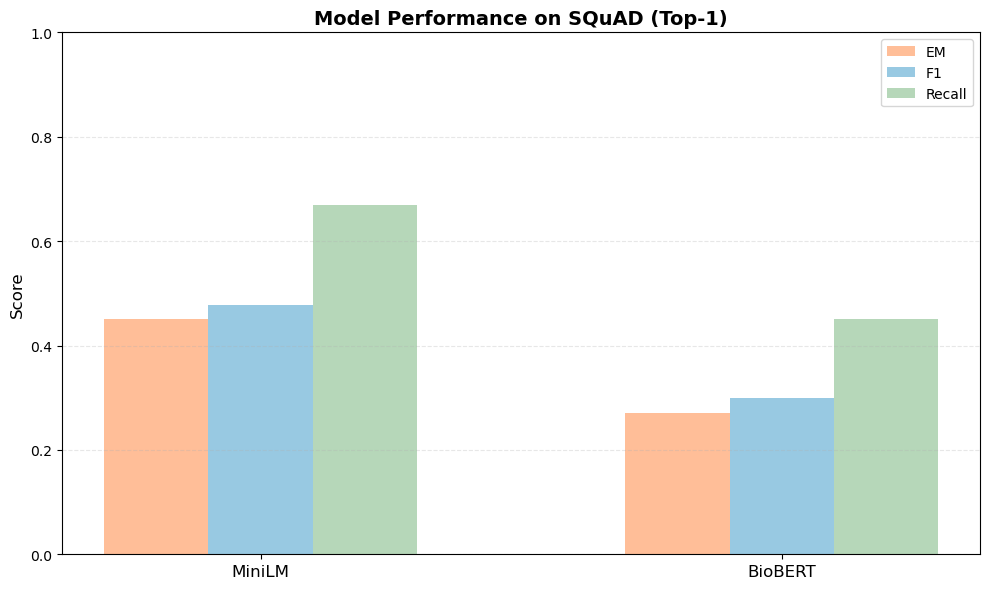

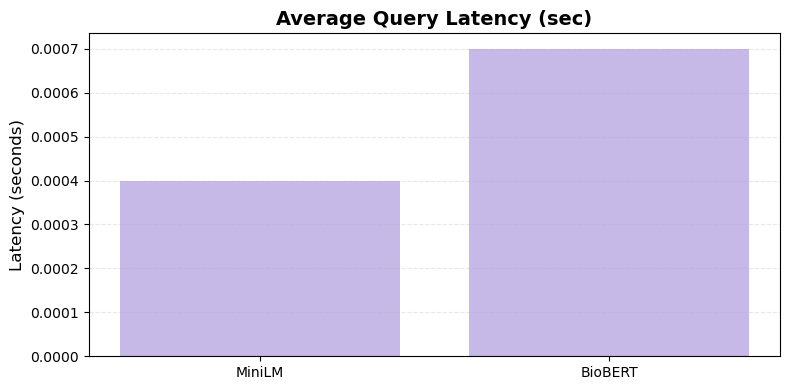

In [ ]:
# Step 7: Visualize the results

import matplotlib.pyplot as plt
import numpy as np

# Define soft color palette for clarity
colors = {
    "EM": "#FFBE98",
    "F1": "#98C9E2",
    "Recall": "#B6D7B9",
    "Latency": "#C6B8E7"
}

# Extract metric values
models = list(results.keys())
em = [results[m]["EM"] for m in models]
f1 = [results[m]["F1"] for m in models]
recall = [results[m]["Recall"] for m in models]
latency = [results[m]["Latency (s)"] for m in models]

x = np.arange(len(models))
width = 0.2

# Plot performance metrics
plt.figure(figsize=(10, 6))
plt.bar(x - width, em, width, label='EM', color=colors["EM"])
plt.bar(x, f1, width, label='F1', color=colors["F1"])
plt.bar(x + width, recall, width, label='Recall', color=colors["Recall"])
plt.xticks(x, models, fontsize=12)
plt.title("Model Performance on SQuAD (Top-1)", fontsize=14, weight='bold')
plt.ylabel("Score", fontsize=12)
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Plot latency
plt.figure(figsize=(8, 4))
plt.bar(models, latency, color=colors["Latency"])
plt.title("Average Query Latency (sec)", fontsize=14, weight='bold')
plt.ylabel("Latency (seconds)", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

